<a href="https://colab.research.google.com/github/aysbt/DataScienceProject/blob/master/Sales_Daily_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Department Solution
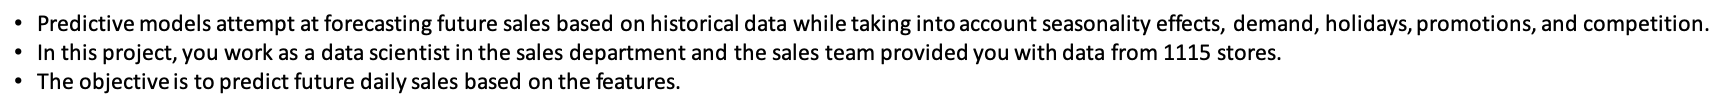

In [55]:
# mount the google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [56]:
#import libraires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()


In [57]:
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/train.csv')
store = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/store.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [59]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Overview of Datsets
**IN TRAIN DATA**
* **Store:** unique store id
* **DayofWeek:** indicate the which date was the sale made. 
* **Date:** Sales date
* **Sales:** Amount of Sales: [Target]
* **Customers: ** The number of customer on a given day
* **Open:** Boolean to say whather a store is open or closed(0=close, 1=open)
* **Promo:** Indicate that the store running a promo on that day or not(1=Yes and 0=No)
* **StateHoliday:** Indicate which State Holiday with a categorical data
   * a = Public holiday
   * b = Easter holiday
   * c = Christmas 
   * 0 = None
* **SchoolHoliday:** indicates if the (Store,Date) was affected by the clousure of public scholls.

**IN STORE DATA**
* **Store:** unique store id
* **StoreType:** categorical varibale to indicate store type (a,b,c,d)
  
* **Assortment:** Different type of stores
  * a = basic
  * b = extra
  * c = extended
* **CompetitionDistance:** Distnace (meters) to closest competitor store.
* **CompetittionOpenSince[Month/Year]:** Date when the competition open
* **Promo2:** is a continuing and consecutive promotion of the some store(0=store is not participating, 1= store is participating)
* **Promo2Since[Week/Year]:** Date when the store started participating in Promo2 
* **PromoInterval:**  describe the consecutive intervals Promo2 is started. There is 3 different categori consist of 4 mount of a year.
  * Jan,Apr,Jul,Oct     
  * Feb,May,Aug,Nov     
  * Mar,Jun,Sept,Dec


In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [61]:
train.describe()
# avarege sales per day is : 5773, maximum salesper day  was: 41551
#avarage number of customer per day: 633 and max customer per day:7388

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [62]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [63]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


## Explore the datasets 

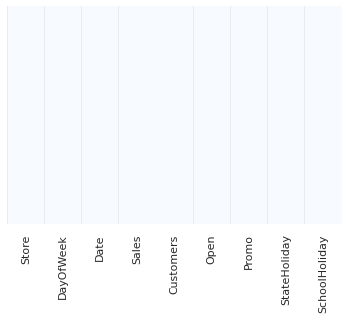

In [64]:
#missing values for train data
sns.heatmap(train.isnull(), yticklabels=False, cbar=False,cmap='Blues')


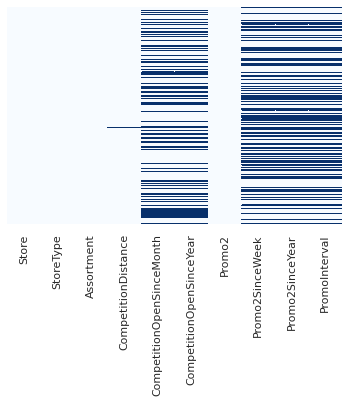

In [65]:
sns.heatmap(store.isnull(), yticklabels=False, cbar=False,cmap='Blues')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95a7896278>,
      dtype=object)

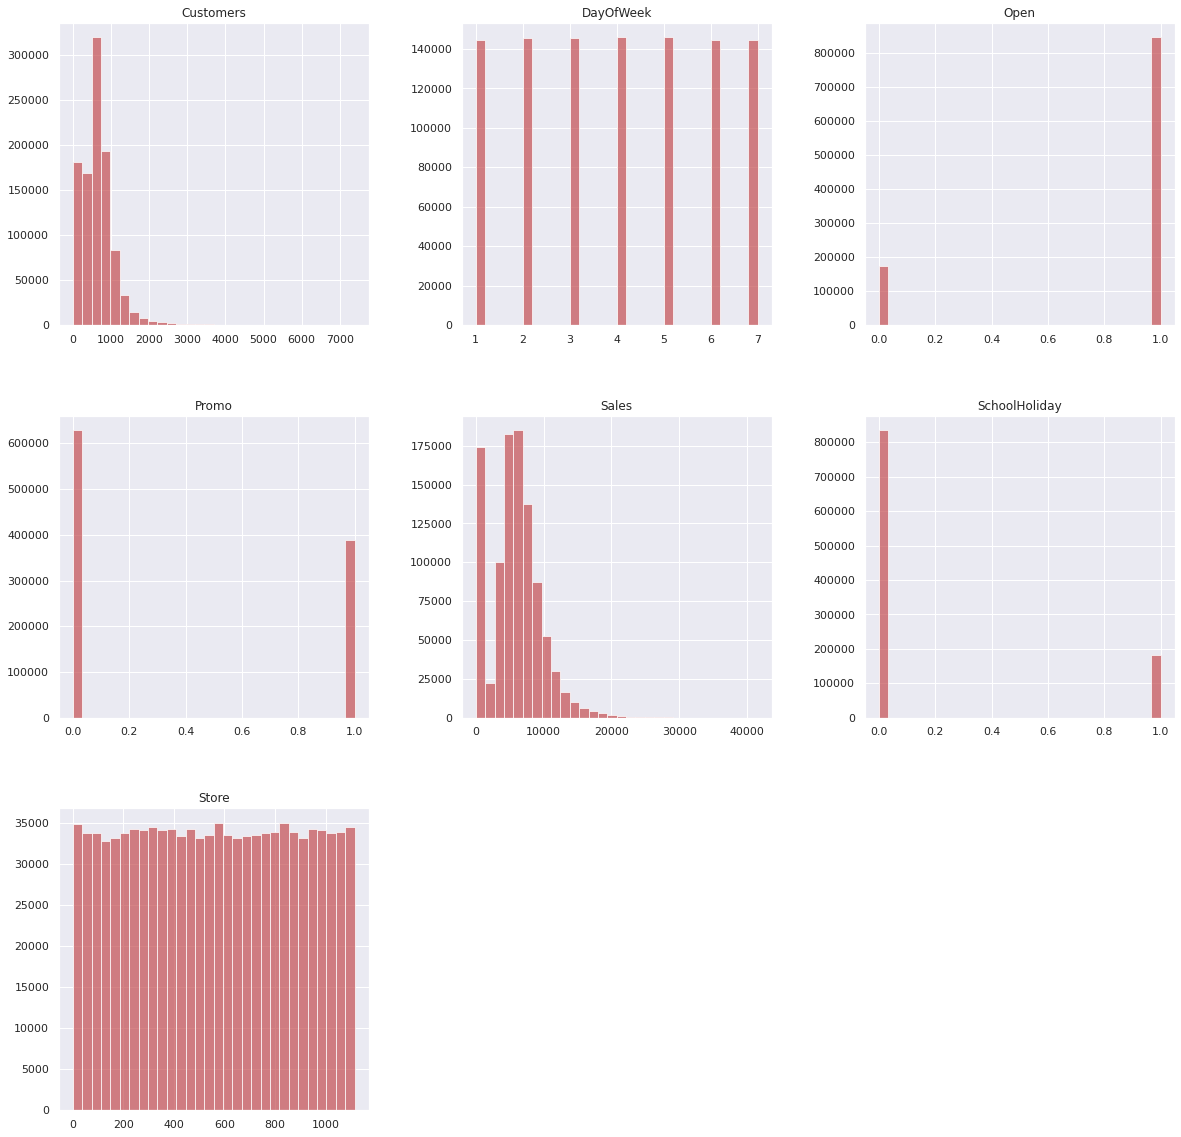

In [66]:
train.hist(bins=30, figsize=(20,20), color='r', alpha=0.7)

In [67]:
train['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [68]:
#get open time data
open_train = train[train['Open']==1]
open_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [69]:
open_train.drop(['Open'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [70]:
open_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [71]:
open_train.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95a84b7b70>,
      dtype=object)

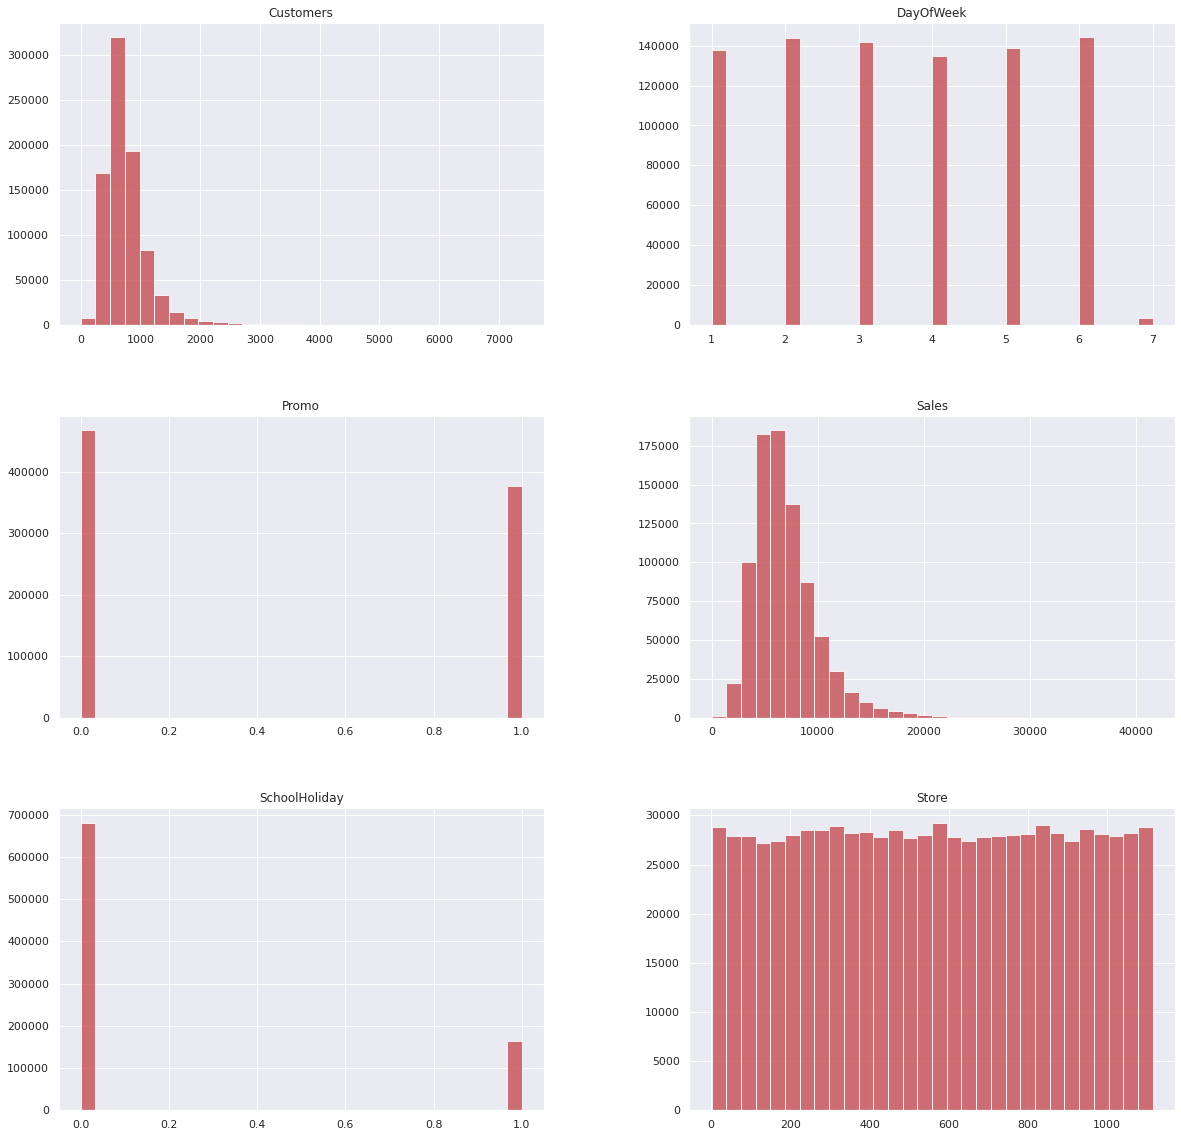

In [72]:
open_train.hist(bins=30, figsize=(20,20), color='r', alpha=0.8)

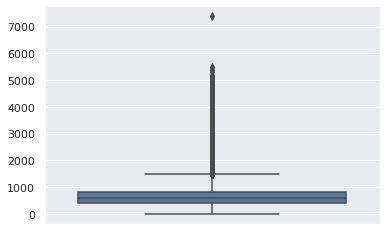

In [86]:
sns.boxplot(y=['Customers'], data=train)

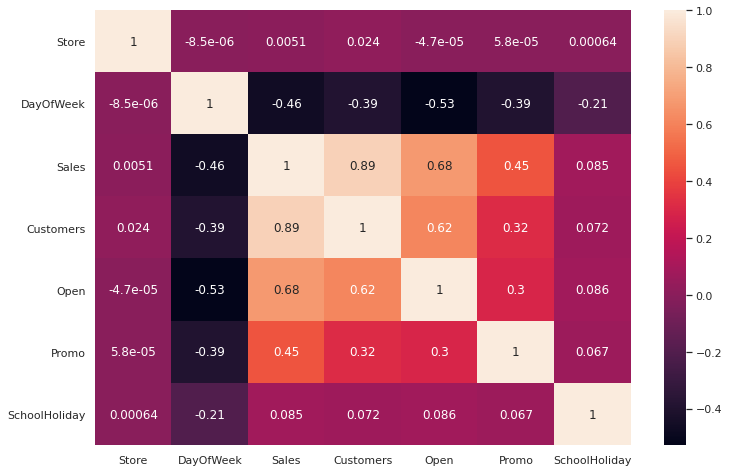

In [95]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), annot=True)

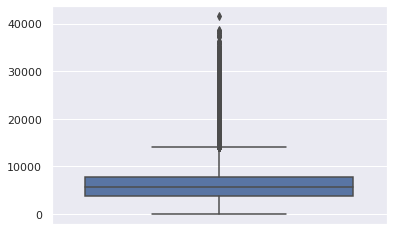

In [82]:
sns.boxplot(y=['Sales'], data=train)

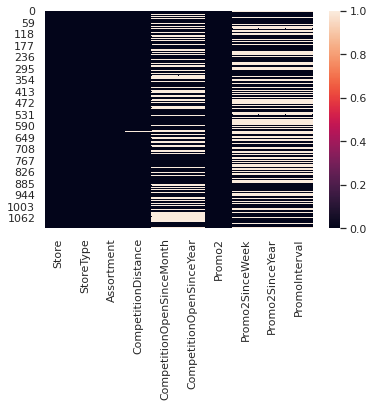

In [73]:
sns.heatmap(store.isnull())

In [97]:
#missing values
store[store['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [98]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [103]:
store[store['Promo2']==0].isnull().sum()
#when the promo2 is 0 so Promo2week and promoyear all NAN
#we are going to fill that value with 0

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            2
CompetitionOpenSinceMonth    148
CompetitionOpenSinceYear     148
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [113]:
#Get null columns more than 100 misssing values
null_columns = []
for col in store.columns:
  if store[col].isnull().sum()>100:
    null_columns.append(col)

print(null_columns)

['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


In [114]:
for col in null_columns:
  store[col].fillna(0, inplace=True)


In [115]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          3
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [117]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace=True)

In [118]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95a64e8748>,
      dtype=object)

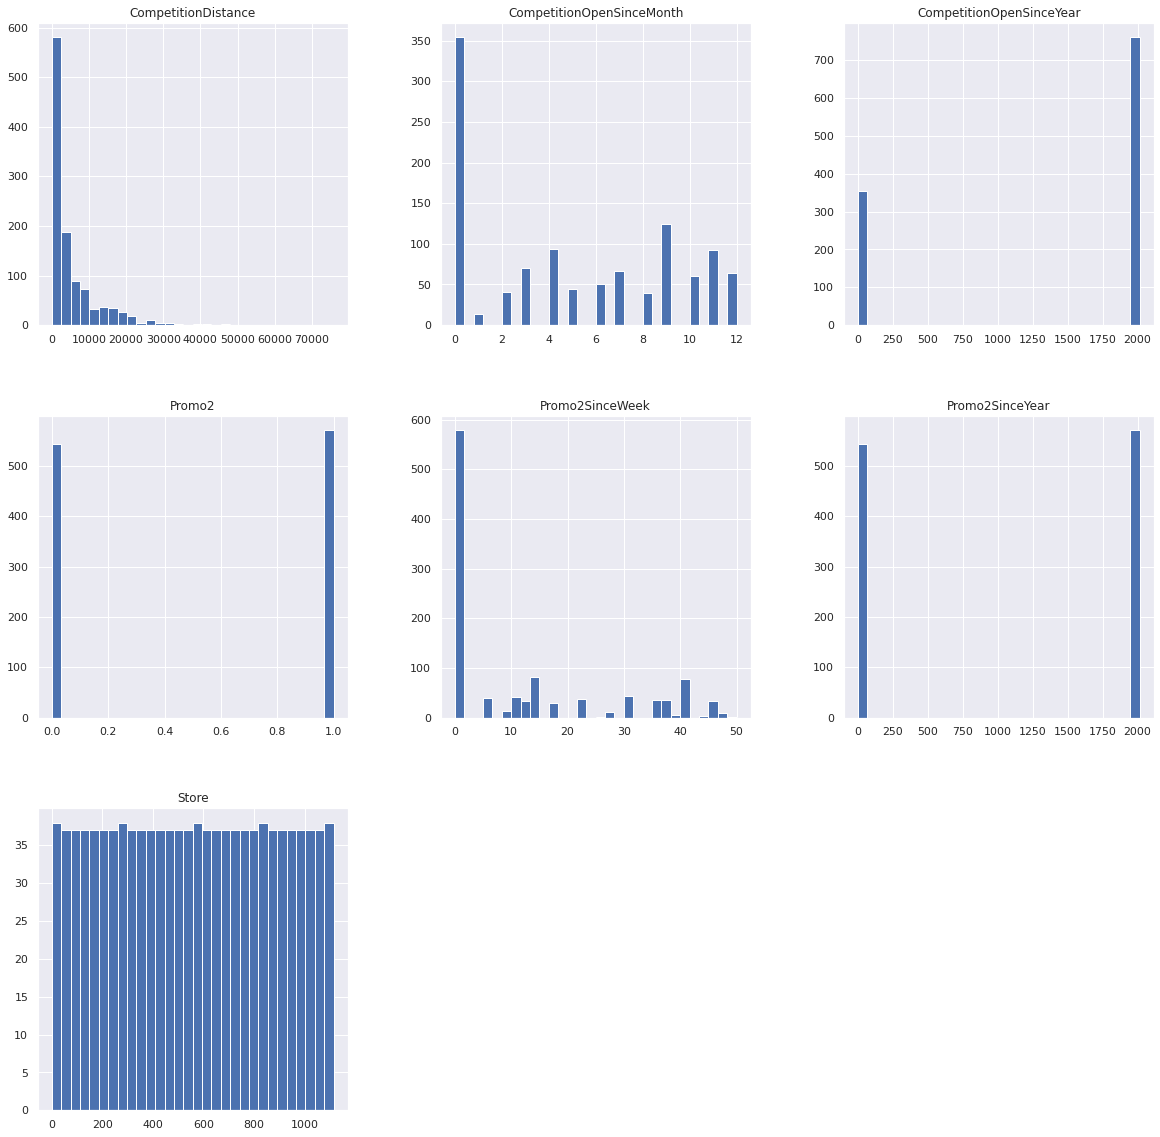

In [119]:
store.hist(bins=30, figsize=(20,20))

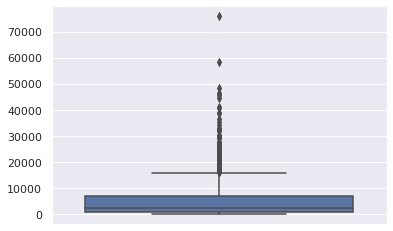

In [120]:
sns.boxplot(y=['CompetitionDistance'], data=store)

In [123]:
#Let's merge out these two datasets
data = pd.merge(train, store, how='inner', on='Store')

In [124]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [125]:
data.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

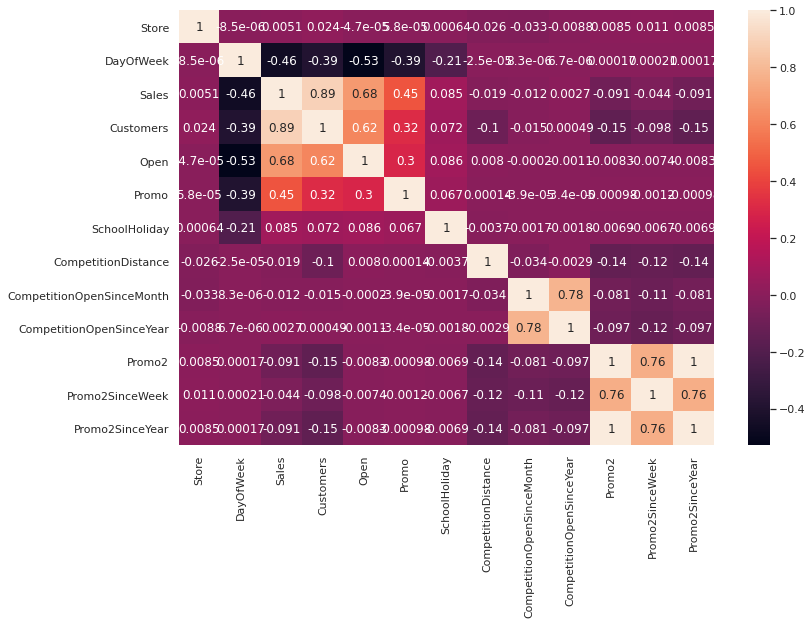

In [126]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, )

In [132]:
data['Year'] =pd.DatetimeIndex(data['Date']).year
data['Month'] =pd.DatetimeIndex(data['Date']).month
data['Day'] =pd.DatetimeIndex(data['Date']).day

In [133]:
data


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,5
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,4
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,3
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,2


In [160]:
#Let's Take a look at average sales and number of customers per month
#gropby works great by grouping all the data share same month column, then obtain the mean of the sales column
#It looks like sales and number of customers peak around the christmas

Month_Sales = data.groupby('Month')['Sales'].agg(['mean'])


In [161]:
Month_Sales

,mean
Month,
1,5465.395529
2,5645.253150
3,5784.578871
4,5738.866916
5,5489.639973
6,5760.964375
7,6064.915711
8,5693.016554
9,5570.246033


Text(0.5, 1.0, 'Avarage Sales Per Month')

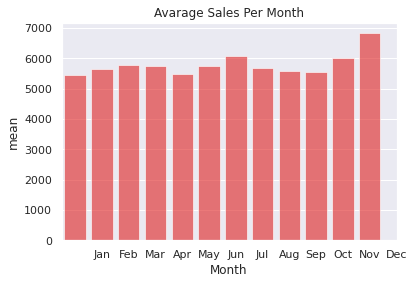

In [196]:
sns.barplot(Month_Sales.index, Month_Sales['mean'], color='red', alpha=0.6)
plt.xticks(np.arange(1,13, step=1), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Avarage Sales Per Month')

Text(0.5, 1.0, 'Avarage Customers Per Month')

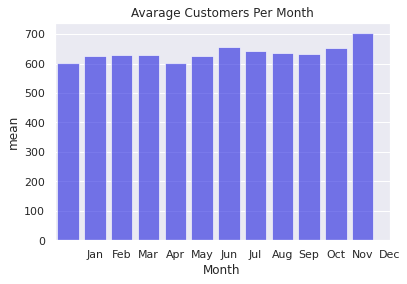

In [197]:

Month_customer = data.groupby('Month')['Customers'].agg(['mean'])
sns.barplot(Month_customer.index, Month_customer['mean'], color='Blue', alpha=0.6)
plt.xticks(np.arange(1,13, step=1), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Avarage Customers Per Month')

In [204]:
Daily = data.groupby('Day')['Sales','Customers'].mean()
Daily.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Sales,Customers
Day,,
1,4658.450603,489.512603
2,6973.664895,735.431686
3,5811.044109,612.213499
4,6818.008362,720.971181
5,6357.150246,675.477199


Text(0.5, 1.0, 'Avarage Sales for Daily')

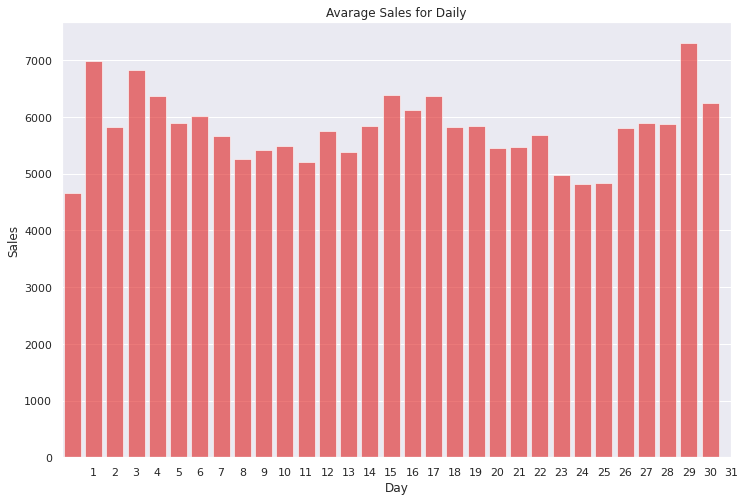

In [198]:
plt.figure(figsize=(12,8))
sns.barplot(Daily.index, Daily['Sales'], color='red', alpha=0.6)
plt.xticks(np.arange(1,32, step=1))
plt.title('Avarage Sales for Daily')

Text(0.5, 1.0, 'Avarage Customers for Daily')

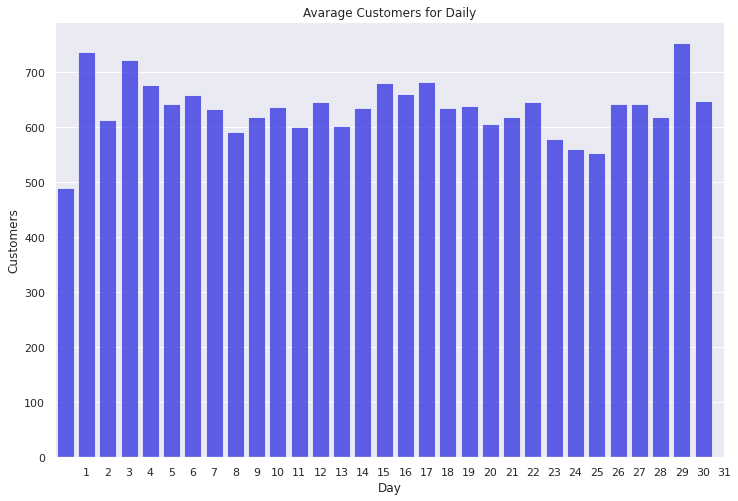

In [201]:
plt.figure(figsize=(12,8))
sns.barplot(Daily.index, Daily['Customers'], color='Blue', alpha=0.7)
plt.xticks(np.arange(1,32, step=1))
plt.title('Avarage Customers for Daily')

In [205]:
DayOfWeek = data.groupby('DayOfWeek')['Sales','Customers'].mean()
DayOfWeek.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Sales,Customers
DayOfWeek,,
1,7809.044510,813.065791
2,7005.244467,760.984615
3,6555.884138,721.639666
4,6247.575913,697.541486
5,6723.274305,743.150742


Text(0.5, 1.0, 'Avarage Sales for Day of Week')

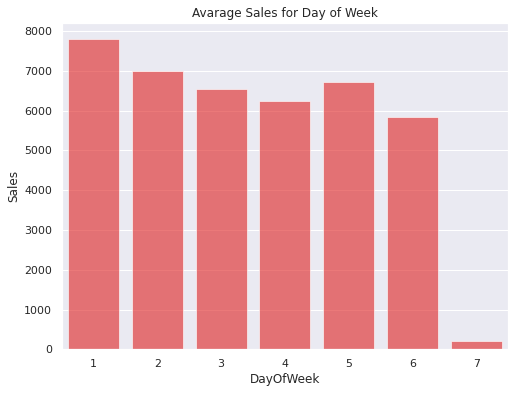

In [212]:
plt.figure(figsize=(8,6))
sns.barplot(DayOfWeek.index, DayOfWeek['Sales'], color='red', alpha=0.6)
plt.title('Avarage Sales for Day of Week')

Text(0.5, 1.0, 'Avarage Customers for Day of Week')

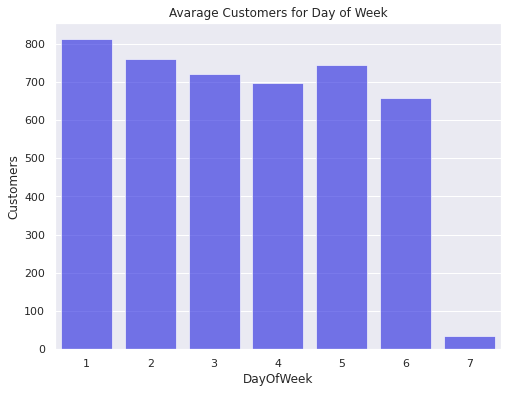

In [213]:
plt.figure(figsize=(8,6))
sns.barplot(DayOfWeek.index, DayOfWeek['Customers'], color='Blue', alpha=0.6)
plt.title('Avarage Customers for Day of Week')

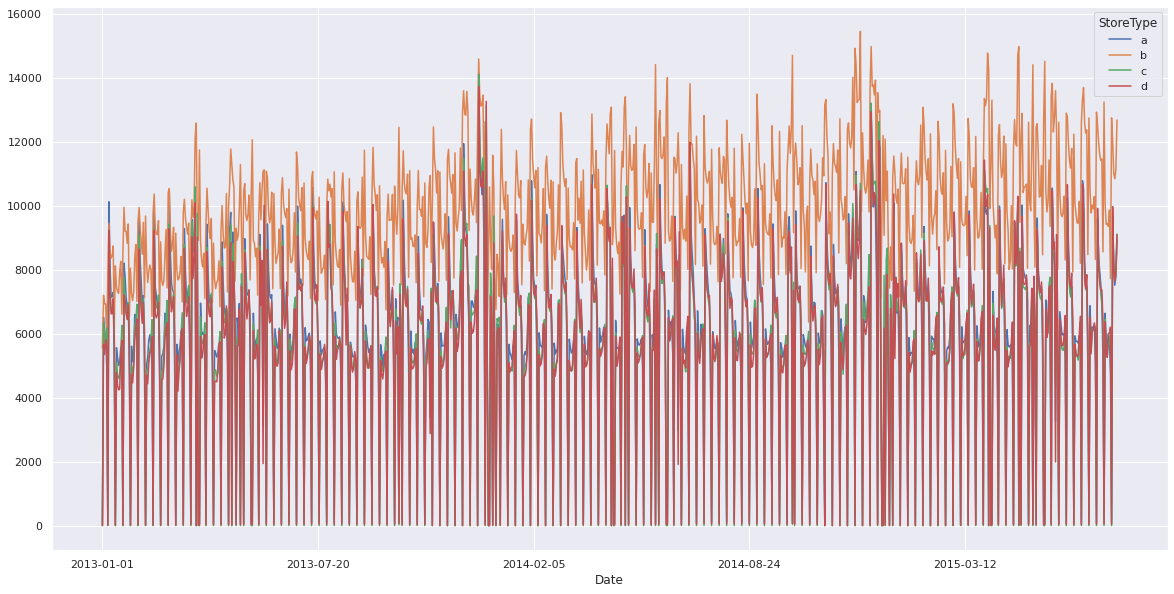

In [217]:
fig, ax= plt.subplots(figsize=(20,10))
data.groupby(['Date','StoreType']).mean()['Sales'].unstack().plot(ax=ax)

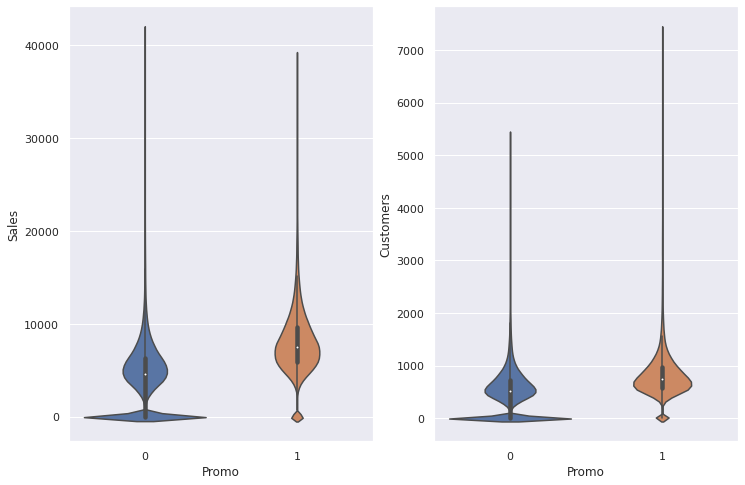

In [220]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.violinplot('Promo','Sales',data=data)

plt.subplot(122)
sns.violinplot('Promo','Customers',data=data)


## FACEBOOK PROPHET 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

https://facebook.github.io/prophet/


In [222]:
from fbprophet import Prophet

In [226]:
# we need data column and sales 
#we need to rename this column Date=date, Sales=y
def sales_prediction(Store_ID, df, periods):
  #perepare the dataset
  df = df[df['Store']==Store_ID]
  df = df[['Date','Sales']].rename(columns = {'Date':'ds','Sales':'y'})
  df = df.sort_values('ds')

  #Create model
  model = Prophet()
  model.fit(df)
  future = model.make_future_dataframe(periods= periods)
  forecast = model.predict(future)
  figure = model.plot(forecast, xlabel='Date',ylabel='Sales')
  figure2 = model.plot_components(forecast)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


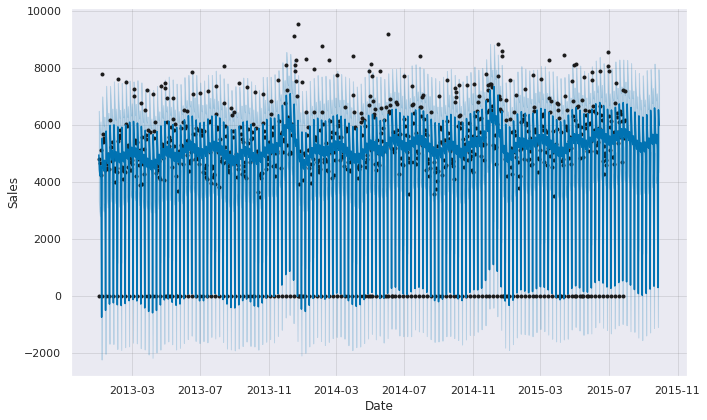

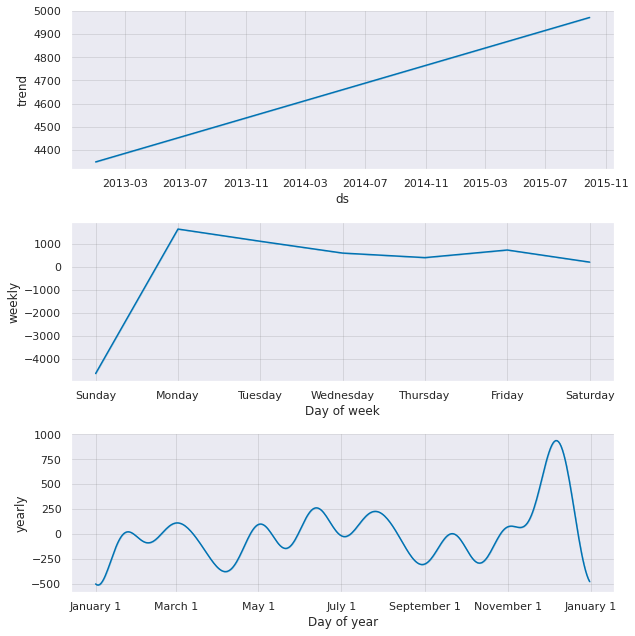

In [227]:
sales_prediction(10, data, 60)

In [236]:
school_holidays = data[data['SchoolHoliday']==1].loc[:,'Date'].values

In [237]:
school_holidays = pd.DataFrame({'ds':pd.to_datetime(school_holidays),
                               'holiday':'school holiday'})


In [238]:
school_holidays.head()

,ds,holiday
0,2015-07-31,school holiday
1,2015-07-30,school holiday
2,2015-07-29,school holiday
3,2015-07-28,school holiday
4,2015-07-27,school holiday


In [241]:
state_holidays = data[(data['StateHoliday']=='a') | (data['StateHoliday']=='b') | (data['StateHoliday']=='c')].loc[:,'Date'].values
state_holidays = pd.DataFrame({'ds':pd.to_datetime(state_holidays),
                               'holiday':'State holiday'})
state_holidays.head()

,ds,holiday
0,2015-06-04,State holiday
1,2015-05-25,State holiday
2,2015-05-14,State holiday
3,2015-05-01,State holiday
4,2015-04-06,State holiday


In [243]:
school_state_holiday = pd.concat((state_holidays, school_holidays))
school_state_holiday

,ds,holiday
0,2015-06-04,State holiday
1,2015-05-25,State holiday
2,2015-05-14,State holiday
3,2015-05-01,State holiday
4,2015-04-06,State holiday
...,...,...
181716,2013-01-05,school holiday
181717,2013-01-04,school holiday
181718,2013-01-03,school holiday
181719,2013-01-02,school holiday


In [244]:
def sales_prediction_with_holiday(Store_ID, sales_df, holidays, periods):
  # Function that takes in the storeID and returns two date/sales columns in Prophet format
  # Format data to fit prophet 

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model    = Prophet(holidays = holidays)
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure2  = model.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


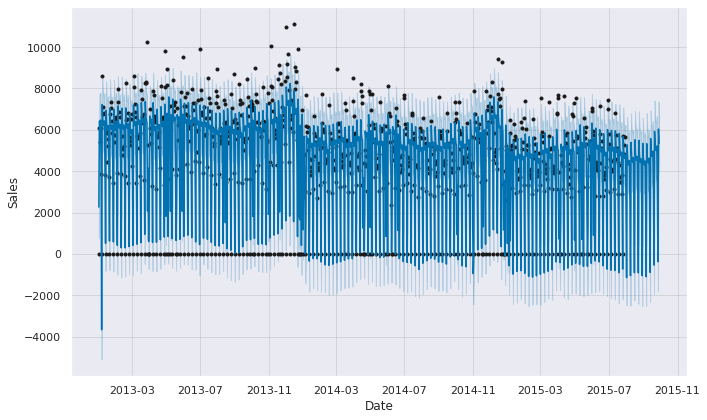

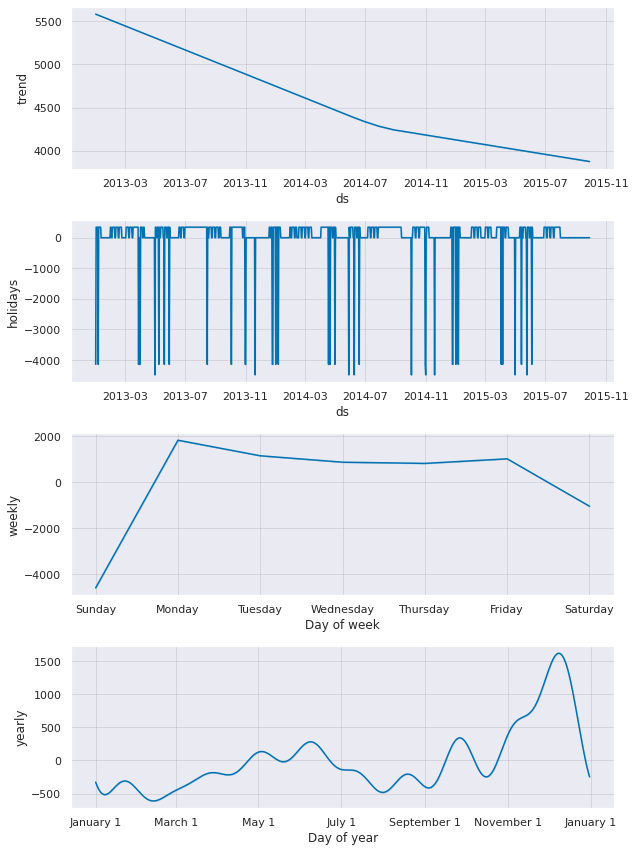

In [245]:
sales_prediction_with_holiday(6, data, school_state_holiday, 60)